#Data Generation

In [12]:
import numpy as np
import csv
def data_generate(fileName, w=[0,0,0]):
    size = 100
    np.random.seed(0)
    x1 = np.random.uniform(-4,4,100)
    x2 = np.random.uniform(-4,4,100)
    noise = np.random.normal(0,3,100)
    v = (x1 * w[0] + x2 * w[1] + w[2] + noise)
    y = (v>0) * 2-1
    data = zip(y, x1, x2)
    with open(fileName,'wb') as f:
        writer = csv.writer(f)
        for row in data:
            writer.writerow(row)
    return True

In [13]:
w = np.array([8, -3, -1])
data_generate('data.csv', w)

True

#Data Visualization

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
def dataPlot(file, w):
    cols = {'1': 'r', '-1': 'b'}
    with open(file,'r') as f:
        reader = csv.reader(f)
        for row in reader:
            plt.plot(float(row[1]), float(row[2]), cols[row[0]]+'o')
    plt.xlabel("x1")
    plt.ylabel("x2")
    x1 = [-4,4]
    x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
    plt.plot(x1, x2, linewidth=2.0)
    plt.grid()
    plt.show()

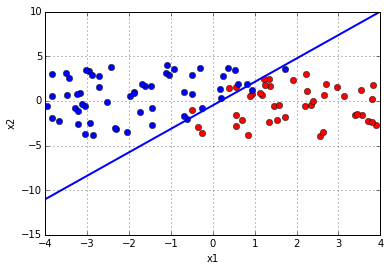

In [18]:
dataPlot('data.csv',w)

#Start Spark

In [5]:
import os
import sys
spark_home = os.environ['SPARK_HOME'] = '/Users/liang/Downloads/spark-1.4.1-bin-hadoop2.6/'
if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.4.1
      /_/

Using Python version 2.7.10 (default, May 28 2015 17:04:42)
SparkContext available as sc, HiveContext available as sqlContext.


#Gradient descent (no regularization)

In [6]:
from collections import namedtuple
import numpy as np
Point = namedtuple('Point', 'x y')

def readPoint(line):
    d = line.split(',')
    x = [float(i) for i in d[1:]]
    x.append(1.0)  #bias term
    return Point(x, float(d[0]))

def logisticRegressionGD(data, wInitial=None, learningRate=0.05, iterations=100):
    featureLen = len(data.take(1)[0].x)
    n = data.count()
    if wInitial is None:
        w = np.random.normal(size=featureLen)
    else:
        w = wInitial
    for i in range(iterations):
        wBroadcast = sc.broadcast(w)
        gradient = data.map(lambda p: (1 / (1 + np.exp(-p.y*np.dot(wBroadcast.value, p.x)))-1) * p.y * np.array(p.x))\
                    .reduce(lambda a, b: a + b)
        w = w - learningRate * gradient / n
    #w = w / np.linalg.norm(w) #normalization
    return w

In [7]:
data = sc.textFile('data.csv').map(readPoint).cache()
logisticRegressionGD(data)

array([ 1.35420091, -0.46407845, -1.01559616])

##Plot w in iterations

In [8]:
def ierationsPlot(fileName, truew):
    x1 = [-4, 4]
    
    w = truew
    x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
    plt.plot(x1, x2, 'b', label="True line", linewidth=4.0)
    
    np.random.seed(800)
    w = np.random.normal(0,1,3)
    x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
    plt.plot(x1, x2, 'r--', label="After 0 Iterations", linewidth=2.0)
    
    data = sc.textFile(fileName).map(readPoint).cache()
    w = logisticRegressionGD(data, w, iterations=30)
    x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
    plt.plot(x1, x2, 'g--', label="After 1 Iterations", linewidth=2.0)
    
    w = logisticRegressionGD(data, w, iterations=30)
    x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
    plt.plot(x1, x2, 'm--', label="After 2 Iterations", linewidth=2.0)
    
    w = logisticRegressionGD(data, w, iterations=30)
    x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
    plt.plot(x1, x2, 'y--', label="After 3 Iterations", linewidth=2.0)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, borderaxespad=0.)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid()
    plt.show()

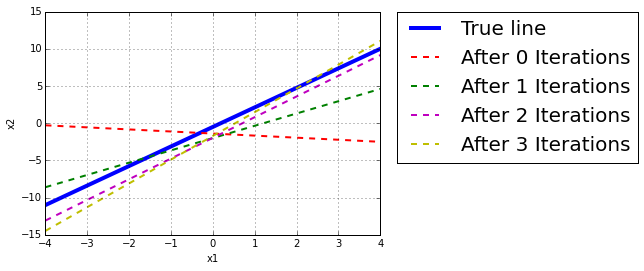

In [9]:
ierationsPlot('data.csv',w)

#Gradient descent (regularization)

In [10]:
def logisticRegressionGDReg(data, wInitial=None, learningRate=0.05, iterations=50, regParam=0.01, regType=None):
    featureLen = len(data.take(1)[0].x)
    n = data.count()
    if wInitial is None:
        w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
    else:
        w = wInitial
    for i in range(iterations):
        wBroadcast = sc.broadcast(w)
        gradient = data.map(lambda p: (1 / (1 + np.exp(-p.y*np.dot(wBroadcast.value, p.x)))-1) * p.y * np.array(p.x))\
                    .reduce(lambda a, b: a + b)
        if regType == "Ridge":
            wReg = w * 1
            wReg[-1] = 0 #last value of weight vector is bias term, ignored in regularization
        elif regType == "Lasso":
            wReg = w * 1
            wReg[-1] = 0 #last value of weight vector is bias term, ignored in regularization
            wReg = (wReg>0).astype(int) * 2-1
        else:
            wReg = np.zeros(w.shape[0])
        gradient = gradient + regParam * wReg  #gradient:  GD of Sqaured Error+ GD of regularized term 
        w = w - learningRate * gradient / n
    return w

##Ridge  Regression

In [11]:
np.random.seed(400)
logisticRegressionGDReg(data, iterations=50, regParam=0.1, regType="Ridge")

array([ 0.74835721, -0.17134752, -0.39953122])

##Lasso  Regression

In [12]:
np.random.seed(400)
logisticRegressionGDReg(data, iterations=50, regParam=0.1, regType="Lasso")

array([ 0.74788215, -0.17092861, -0.397468  ])